# 🎯 Emotion Detection with LSTM (With Output Prints)

## 📥 Step 1: Load and Balance the Dataset

In [2]:
import pandas as pd
from sklearn.utils import resample

print("🔹 Loading dataset...")
train_df = pd.read_csv("/training.csv")
print("Original label distribution:")
print(train_df['label'].value_counts())

# Upsample
print("\n🔹 Balancing the dataset with upsampling...")
max_count = train_df['label'].value_counts().max()
balanced_dfs = []

for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_dfs.append(upsampled)

balanced_df = pd.concat(balanced_dfs)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced label distribution:")
print(balanced_df['label'].value_counts())

🔹 Loading dataset...
Original label distribution:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

🔹 Balancing the dataset with upsampling...
Balanced label distribution:
label
2    5362
0    5362
1    5362
5    5362
3    5362
4    5362
Name: count, dtype: int64


## 🧽 Step 2: Clean the Text

In [5]:
import re
import pandas as pd

# 🔹 1. Clean text function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower().strip()
    return text

# 🔹 2. Clean the balanced_df
print("\n🔹 Cleaning text data...")
balanced_df['Cleaned_Text'] = balanced_df['text'].apply(clean_text)
print(balanced_df[['text', 'Cleaned_Text']].head(3))

# 🔹 3. Label map used by the model
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
# Invert it for string to int conversion
label_inverse_map = {v: k for k, v in label_map.items()}

# 🔹 4. Create custom nuanced emotion samples
custom_data = pd.DataFrame({
    'text': [
        "You always know exactly what I need.",
        "I never knew someone could care this much.",
        "Thank you… I don’t even have the words.",
        "You made my entire day with that gesture.",
        "Wait… what? Seriously? You did that?",
        "I didn’t expect that. You made my day.",
        "I feel so loved and supported right now.",
        "You did all this… for me?",
        "That was the sweetest thing anyone’s ever done.",
        "I’m honestly speechless right now — wow!"
    ],
    'label': [
        label_inverse_map['love'], label_inverse_map['love'], label_inverse_map['love'],
        label_inverse_map['love'], label_inverse_map['surprise'], label_inverse_map['surprise'],
        label_inverse_map['love'], label_inverse_map['love'], label_inverse_map['love'],
        label_inverse_map['surprise']
    ]
})

# 🔹 5. Clean text for custom samples
custom_data['Cleaned_Text'] = custom_data['text'].apply(clean_text)

# 🔹 6. Clean up: remove any old string-labeled rows if they exist
balanced_df = balanced_df[~balanced_df['label'].isin(['love', 'surprise'])]

# 🔹 7. Append fixed custom samples to the main balanced_df
balanced_df = pd.concat([balanced_df, custom_data], ignore_index=True)

# 🔹 8. Final check
print("✅ Added custom emotion samples with numeric labels.")
print("✅ Final shape:", balanced_df.shape)
print("✅ Final label distribution:")
print(balanced_df['label'].value_counts())


🔹 Cleaning text data...
                                                text  \
0  i feel a lot of shame in not having many roman...   
1  i still have feelings for him only broke up fo...   
2                       i feel accepted for who i am   

                                        Cleaned_Text  
0  i feel a lot of shame in not having many roman...  
1  i still have feelings for him only broke up fo...  
2                       i feel accepted for who i am  
✅ Added custom emotion samples with numeric labels.
✅ Final shape: (32192, 3)
✅ Final label distribution:
label
2    5376
5    5368
0    5362
1    5362
3    5362
4    5362
Name: count, dtype: int64


## 🔡 Step 3: Tokenize and Encode the Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

print("\n🔹 Tokenizing text with 10k vocab and maxlen=150...")
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['Cleaned_Text'])

sequences = tokenizer.texts_to_sequences(balanced_df['Cleaned_Text'])
X = pad_sequences(sequences, maxlen=150)

print("🔸 Tokenized sample:\n", sequences[:2])
print("🔸 Padded shape:", X.shape)

print("\n🔹 Encoding labels...")
le = LabelEncoder()
y = le.fit_transform(balanced_df['label'])
print("🔸 Encoded label sample:", y[:5])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("🔸 Train/Val split:", X_train.shape, X_val.shape)


🔹 Tokenizing text with 10k vocab and maxlen=150...
🔸 Tokenized sample:
 [[2, 3, 7, 167, 10, 2297, 12, 27, 174, 142, 354, 872, 12, 6, 335], [2, 62, 21, 104, 17, 70, 115, 832, 42, 17, 7, 833, 35, 16, 82, 410, 165, 32, 6, 236, 4, 2, 67, 70, 100, 29, 155]]
🔸 Padded shape: (32192, 150)

🔹 Encoding labels...
🔸 Encoded label sample: [2 0 2 2 1]
🔸 Train/Val split: (25753, 150) (6439, 150)


## 🧠 Step 4: Build and Train LSTM Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("\n🔹 Building LSTM model...")
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),  # 🔁 Match tokenizer's num_words
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("\n🔹 Training model...")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,  # 🔽 Smaller batch size = better generalization
    callbacks=[early_stop]
)


🔹 Building LSTM model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🔹 Training model...
Epoch 1/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 216s 264ms/step - accuracy: 0.4594 - loss: 1.2955 - val_accuracy: 0.9342 - val_loss: 0.2035
Epoch 2/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 268s 271ms/step - accuracy: 0.9574 - loss: 0.1535 - val_accuracy: 0.9685 - val_loss: 0.1016
Epoch 3/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 281s 294ms/step - accuracy: 0.9831 - loss: 0.0624 - val_accuracy: 0.9700 - val_loss: 0.1092
Epoch 4/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 246s 275ms/step - accuracy: 0.9847 - loss: 0.0506 - val_accuracy: 0.9731 - val_loss: 0.1206
Epoch 5/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 254s 265ms/step - accuracy: 0.9904 - loss: 0.0336 - val_accuracy: 0.9752 - val_loss: 0.1150


## 📊 Step 5: Evaluate Model Performance


🔹 Plotting training history...


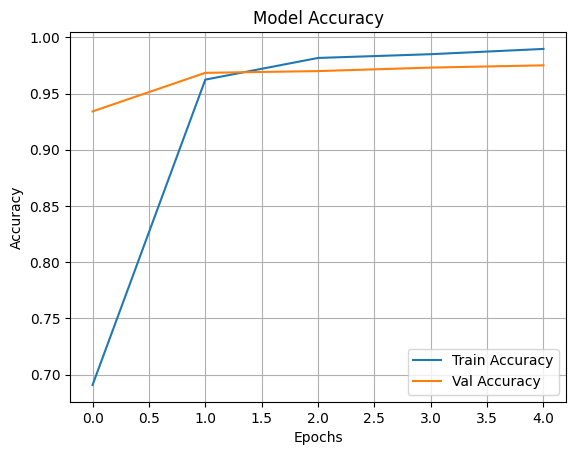

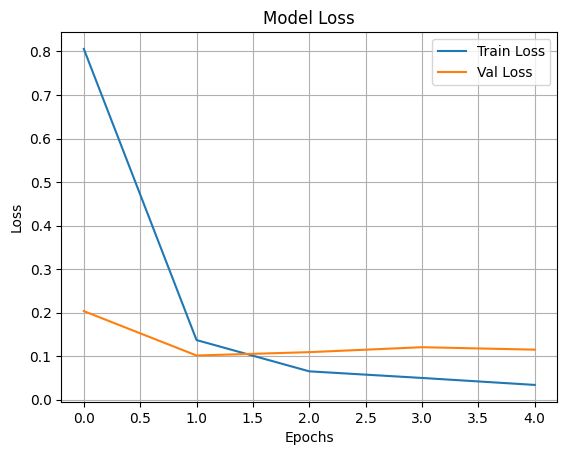

In [10]:
import matplotlib.pyplot as plt

print("\n🔹 Plotting training history...")

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

## 💾 Step 6: Save Model, Tokenizer, and Label Map

In [11]:
print("\n🔹 Saving model and artifacts...")

model.save("emotion_model.h5")
print("✅ Saved model to emotion_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Saved tokenizer to tokenizer.pkl")

label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
with open("label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)
print("✅ Saved label map to label_map.pkl")


🔹 Saving model and artifacts...
✅ Saved model to emotion_model.h5
✅ Saved tokenizer to tokenizer.pkl
✅ Saved label map to label_map.pkl


In [12]:
from google.colab import files

files.download("emotion_model.h5")
files.download("tokenizer.pkl")
files.download("label_map.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>